In [4]:
import pandas as pd
from tensorflow.keras import models
from tensorflow.keras import layers 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'keras.wrappers'

In [105]:
df = pd.read_csv('final_data.csv')

df.shape

# select sequential model for simplicity. Model does not need to allow for nonlinear data flow or custom architecture
network = models.Sequential()

network.add(layers.Dense(512,activation='relu', input_shape=(20,)))
network.add(layers.Dense(1,activation='sigmoid'))

network.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics = ['accuracy'])

# Set up 70/30 train/test split
X = df.drop(columns=['readmitted'])
y=df['readmitted']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Validaion set size: {len(X_val)} samples")



Training set size: 45614 samples
Test set size: 15205 samples
Validaion set size: 15205 samples


C:\Users\jefel\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [106]:
history = network.fit(X_train, y_train, epochs = 20, batch_size = 512, validation_data=(X_val, y_val))

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6624 - loss: 0.6151 - val_accuracy: 0.8422 - val_loss: 0.4129
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8524 - loss: 0.3849 - val_accuracy: 0.8614 - val_loss: 0.3395
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.3402 - val_accuracy: 0.8610 - val_loss: 0.3291
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.3345 - val_accuracy: 0.8615 - val_loss: 0.3270
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - loss: 0.3314 - val_accuracy: 0.8612 - val_loss: 0.3276
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8590 - loss: 0.3284 - val_accuracy: 0.8602 - val_loss: 0.3246
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8575 - loss: 0.3274 - val_accuracy: 0.8617 - val_loss: 0.3241
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3270 - val_accuracy: 0.8574 - val_loss:

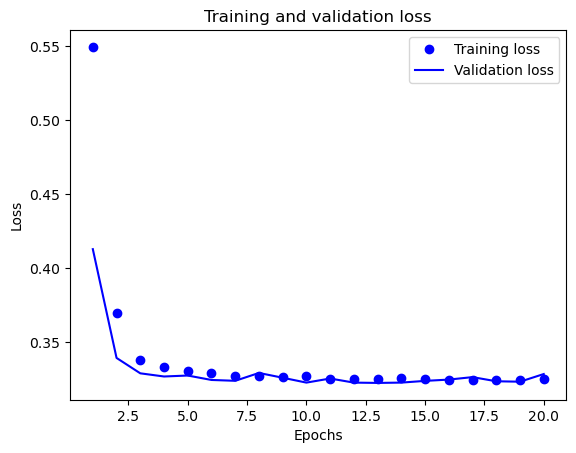

In [107]:
# plot the loss
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
acc = history_dict['accuracy']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training loss") # blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

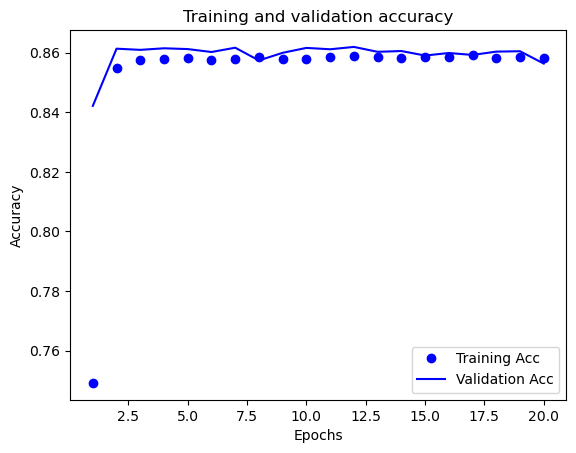

In [108]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation Acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [109]:
test_loss,test_acc = network.evaluate(X_test,y_test)
print('test accuracy:', test_acc)

y_pred_prob = network.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.8521 - loss: 0.3326
test accuracy: 0.8533377051353455
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
Precision: 0.9404587603709127


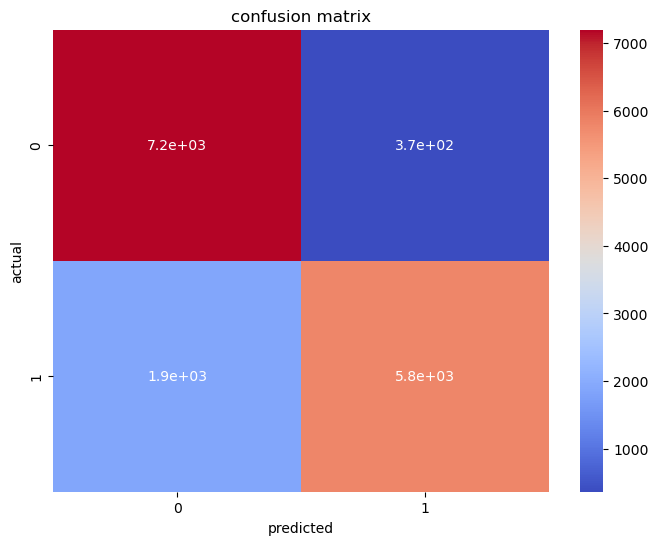

In [110]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap = 'coolwarm')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('actual')

plt.show()

# Confusion matrix shows we have no false positives (no one was predicted to be readmitted but actually never came in)
# We did have false negatives (predicted to not be readmitted but ended up being readmitted)
# For this model, we would prefer to have more false positives than false negatives. 

In [2]:
tp = cm[1,1]
tn = cm[0,0]
fp = cm[1,0]
fn = cm[0,1]

recall = tp / (tp + fn)
recall

NameError: name 'cm' is not defined

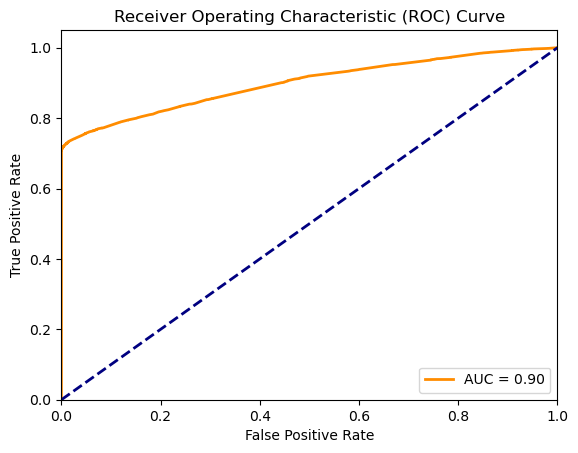

In [111]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()